In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from skimage.morphology import dilation, square

from utils import *

In [2]:
def clahe(X_bbox, cl, gs):
    clahe = cv2.createCLAHE(clipLimit=cl*gs*gs, tileGridSize=(gs, gs))
    img = X_bbox
    img *= (255.0 / img.max())
    img = img.astype('uint8')
    img = clahe.apply(img)
    img = np.array(img)
    return img


def crop_bbox(X):
    X_bbox = []
    img_size = 512
    ymin, ymax, xmin, xmax = bbox2_square(X[:,:,1])
    img = X[:,:,0].astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min())
    bbox = img[ymin:ymax+1, xmin:xmax+1]
    bbox = cv2.resize(bbox, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
    X_bbox.append(bbox)
    return bbox

# Data plot for pre-processing
---
The input samples were processed using a lung segmentation model developed by Illia Ovcharenko [GitHub source](https://github.com/IlliaOvcharenko/lung-segmentation/tree/master)

After segmentation, the input array for further processing should have the dimensions (N, 512, 512, 2), where the first channel is the original grayscale X-ray image, and the second channel is the binary mask of lung segments obtained from Ovcharenko's model.

ID:A408459 Label:True


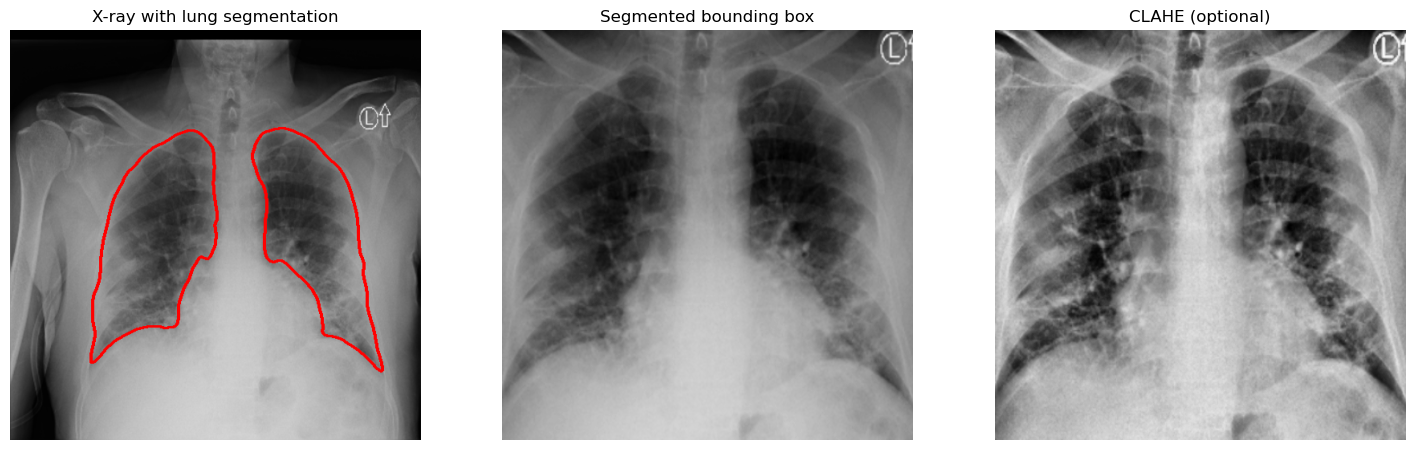

ID:A114403 Label:False


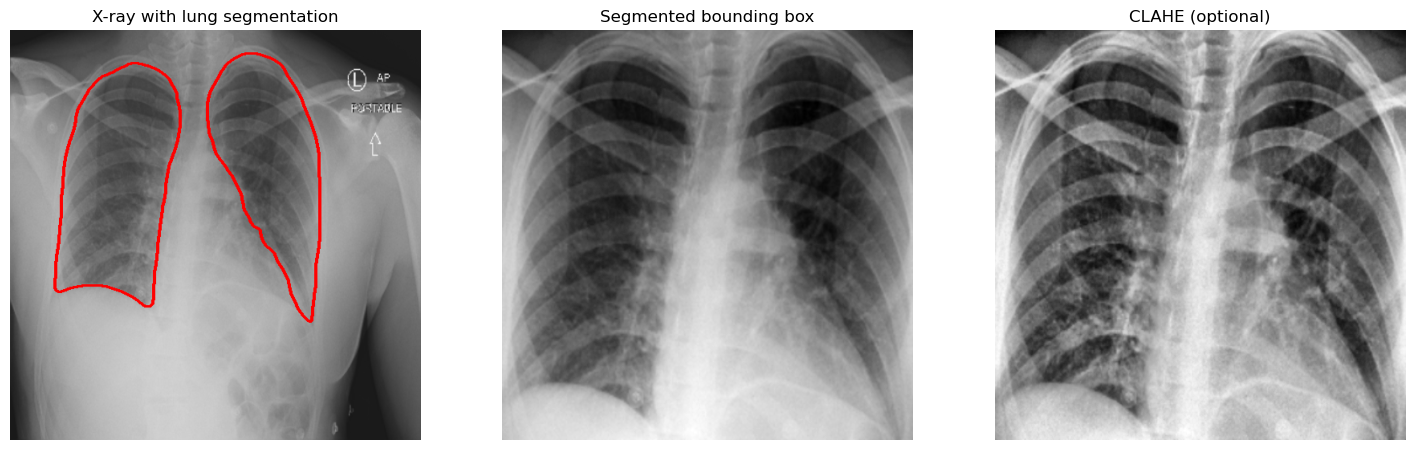

ID:A179258 Label:False


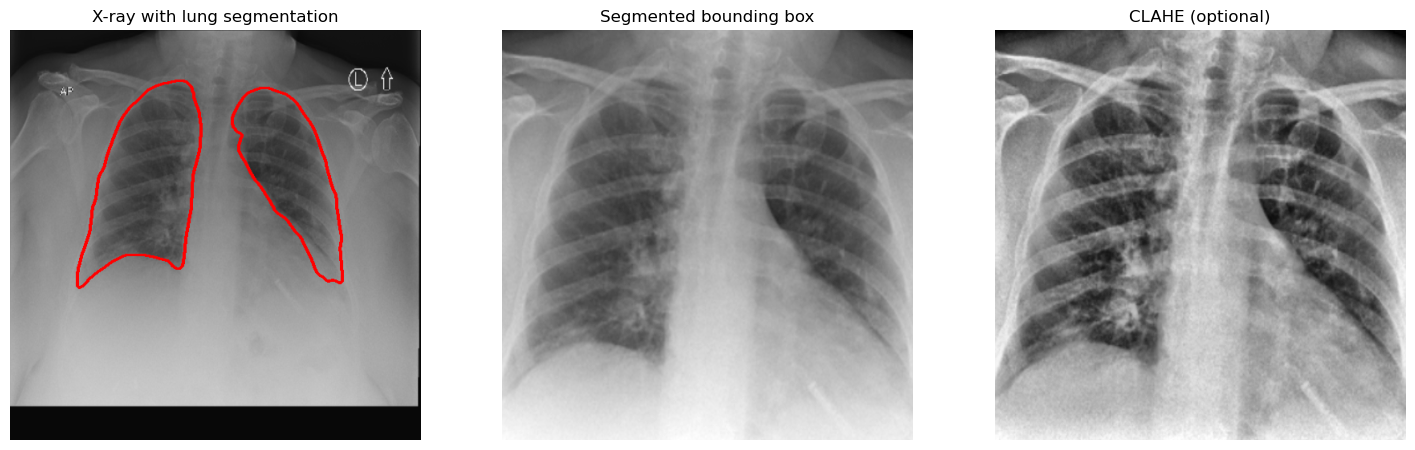

In [67]:
nysbu_data = np.load('./data/sample_nysbu_x.npy')
nysbu_label = pd.read_csv('./data/sample_nysbu_y.csv')
ricord_data = np.load('./data/sample_ricord_x.npy')
ricord_label = pd.read_csv('./data/sample_ricord_y.csv')

data = nysbu_data
label = nysbu_label
# Display random images
num_images = 3
for i in range(num_images):
    num = random.randint(0, len(data) - 1)
    img = data[num]
    sid = label.iloc[num,0]
    icu = label.iloc[num,1]
    print(f"ID:{sid} Label:{icu}")
    xray, mask = img[:,:,0], img[:,:,1]
    xray = (xray - xray.min()) / (xray.max() - xray.min()) 

    # Convert mask to integer
    mask = (mask * 1).astype(int)

    # Find boundaries of the mask and then dilate
    mask_boundaries = find_boundaries(mask, mode='outer')
    thick_boundaries = dilation(mask_boundaries, square(3))  # Adjust the size (3) to change thickness

    # Create a color image from grayscale xray
    color_image = np.stack((xray, xray, xray), axis=-1)

    # Overlay the thick boundaries on the color image
    color_image[thick_boundaries] = [1, 0, 0]  # Red color for boundaries
    
    cropped_image = crop_bbox(img)
    cropped_image = (cropped_image - xray.min()) / (xray.max() - xray.min()) 
    clahe_image = clahe(cropped_image, .04, 8)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(color_image)
    axes[0].set_title('X-ray with lung segmentation')
    axes[0].axis('off')

    axes[1].imshow(cropped_image, cmap='gray')
    axes[1].set_title('Segmented bounding box')
    axes[1].axis('off')

    axes[2].imshow(clahe_image, cmap='gray')
    axes[2].set_title('CLAHE (optional)')
    axes[2].axis('off')
    plt.show()

